In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from abc import ABC, abstractmethod
from subprocess import call
from IPython.display import Image
from sklearn.model_selection import train_test_split as dataSplitter
from sklearn.model_selection import GridSearchCV
from sklearn.base import ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier as skKNN
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz

In [199]:
#in future version add roc inside here 
class Algo:
	def __init__(self,trainData,testData):
		self.classifier  = ClassifierMixin()
		self.train(trainData)
		self.test = testData
	@abstractmethod
	def train(self,data):
		pass
	@abstractmethod
	def getName(self,data):
		pass
	def score(self):
		print("test score = "+str(self.classifier.score(self.test.drop(['isPhoton'],axis=1),self.test['isPhoton'])))
	def best_param(self):
		print(self.classifier.best_params_)
	def estimate(self,cluster):
		return self.classifier.predict_proba(cluster)
	def make_roc(self):
		#print(self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1])
		return roc_curve(self.test['isPhoton'],self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1])

In [200]:
class Sasha(Algo):
    def __intit__(self,trainData,testData):
        Algo.__init__(trainData,testData)
    def train(self,data):
        #does nothing algo comes pretrained
        return
    def getName(self):
        return "Sasha"
    def estimate(self,cluster):
        estimates = cluster['sProb'].values
        return estimates
    def make_roc(self):
        return roc_curve(self.test['isPhoton'],self.estimate(self.test))

In [201]:
class kNN(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(skKNN(),{'n_neighbors':[24,32,38]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "kNN"

In [202]:
class LDA(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(skLDA(solver='lsqr'),{'tol':[1e-4,1e-5,1e-3]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "LDA"

In [230]:
class Logistic(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)

	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear',max_iter=1000,class_weight={1: .005, 0:.995}),{'tol':[1e-4,1e-5,1e-4],'C':[.1,1,10]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "Logistic"

In [204]:
class BDT(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(AdaBoostClassifier(),{'n_estimators':[10000,1000],'learning_rate':[.1,1,.01]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "BDT"

In [235]:
class RandomForest(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(RandomForestClassifier(class_weight={1:.005,0:.995}),{'n_estimators':[250,500]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "RandomForest"

In [206]:
class MLP(Algo):
	def __intit__(self,trainData,testData):
		trainData, testData = scaler(trainData,testData)
		Algo.__init__(trainData,testData)
		self.name="MLP"
	def scaler(self,train,test):
		_scaler = StandardScaler()
		_scaler.fit_transform(train)
		_scaler.transform(test)
		return train, test
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(MLPClassifier(early_stopping=True,warm_start=True),{'alpha':[1e-4,1e-3,1e-5],'learning_rate_init':[1e-2,1e-3,1e-1],'epsilon':[1e-9,1e-8,1e-10],'hidden_layer_sizes':[[17,17]]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "MLP"

In [207]:
def pid2Type(val):
    if abs(val) in [311,313,421,423,511,513,111,113,130,221,331]:
        return 0
    else:
        return 1

In [208]:
def plotRoc(algos):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure()
    plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y','c','k'])))
    lw = len(algos) + 1
    for algo in algos:
        print(algo.getName())
        fpr[algo], tpr[algo],_ = algo.make_roc()
        roc_auc[algo] = auc(fpr[algo],tpr[algo])
        plt.plot(fpr[algo], tpr[algo],
         lw=lw, label=algo.getName()+' (area = %0.2f)' % roc_auc[algo])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [209]:
def diagnoseForest(model,names):
    index = 0
    #for estimator in model.estimators_:
    estimator = model.estimators_[5]
    title = 'tree'+str(index)+'.dot'
    export_graphviz(estimator, out_file=title, 
                feature_names = names,
                class_names = ['Jet','Photon'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
    newTitle = 'tree'+str(index)+'.png'
        #call(['dot','-Tpng', title, '-o', newTitle, '-Gdpi=600'])
    Image(filename = newTitle)
    index = index+1

In [210]:
def removeCombined(val):
    if val == -998:
        return np.nan
    else:
        return val

In [211]:
def csvToInput(signal,back):
    dfs = pd.read_csv(signal)
    dfb = pd.read_csv(back)
    df = dfs.append(dfb)
    df = df.groupby(['isPhoton']).get_group(1)
    df= df.drop(['isPhoton'], axis=1)
    df['pid'] = df['pid'].apply(removeCombined)
    df = df.dropna()
    df['pid'] = df['pid'].apply(pid2Type)
    df = df.rename(columns = {'pid':'isPhoton'})
    df = df[df['total_energy']>3]
    #groups = df.groupby(['pid'])
    #photons = groups.get_group(22)
    #photons['total_energy'].hist()
    #return photons
    train, test = dataSplitter(df.values,test_size=.2,shuffle=True)
    train = pd.DataFrame(columns=df.columns,data=train)
    test = pd.DataFrame(columns=df.columns,data=test)
    return train,test

In [212]:
train, test = csvToInput("photonClusters.csv","backclusters.csv")
trainS = train
testS = test
train = train.drop(['sProb'],axis=1)
test = test.drop(['sProb'],axis=1)
train.head()

,Unnamed: 0,total_energy,cal_energy,core_energy,isPhoton,tower0,tower1,tower2,tower3,tower4,...,tower39,tower40,tower41,tower42,tower43,tower44,tower45,tower46,tower47,tower48
0,2255.0,11.748562,1170.804321,9.638638,0.0,0.062700,-0.029536,0.015509,0.024089,-0.029536,...,-0.024287,-0.024287,0.082425,-0.024287,0.018118,0.090812,0.298798,-0.024287,-0.024287,-0.024287
1,381.0,14.591228,1125.869019,14.824283,0.0,-0.037123,-0.037123,-0.037123,-0.037123,-0.037123,...,0.174272,0.127385,0.012299,-0.028194,-0.028194,-0.028194,-0.028194,0.238209,-0.028194,-0.028194
2,5214.0,14.909240,1436.518921,13.382023,0.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-0.034163,0.033457,0.031344,-0.034163,0.113756,0.232092,0.025004,0.101077,0.079946,-0.034163
3,75.0,15.122783,1125.690186,15.452497,0.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-0.029387,0.010536,-0.029387,0.054661,-0.029387,-0.029387,0.025244,-0.029387,-0.029387,-0.029387
4,2140.0,7.132199,1255.006958,7.321467,0.0,0.274340,0.137397,0.153508,0.083022,0.135383,...,-999.000000,-999.000000,-999.000000,-0.025220,-0.025220,0.302946,-0.025220,-0.025220,0.075589,0.360858


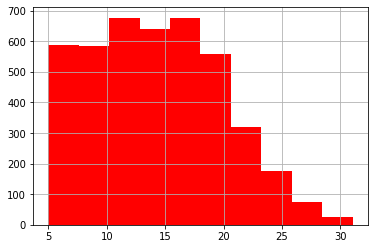

In [213]:
train['total_energy'].hist()

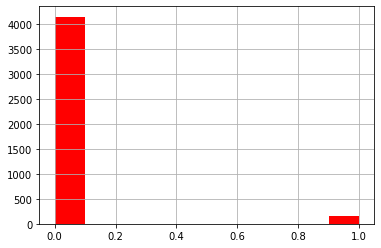

In [214]:
train['isPhoton'].hist()

In [215]:
sasha = Sasha(trainS,testS)

In [216]:
def toNA(val):
    if val==-999:
        return np.nan
    else:
        return val

In [217]:
def to0(val):
    if val==-999:
        return 0
    else:
        return val

Try to make some engineered features based off the symmetry of a photon.

In [218]:
def integrated_perimeter(df):
    perimeter_values = [1,2,3,4,5,6,7,13,14,20,21,27,28,34,35,41,42,43,44,45,46,47,48]
    name = 'tower'
    df['integrated_perimeter'] = df['tower0']
    #df.drop(['tower0'])
    for i in perimeter_values:
        title = name+str(i)
        df['integrated_perimeter'] = df['integrated_perimeter']+df[title]
        #df.drop([title])
    return df
        

In [219]:
def max_finder(df):
    perimeter_values = [9,10,11,12,15,19,22,26,29,33,36,37,38,39,40]
    name = 'tower'
    df['max_perimeter'] = df['tower8']
    #df.drop(['tower0'])
    for i in perimeter_values:
        title = name+str(i)
        df['max_perimeter'] = df['max_perimeter']+df[title]
        #df.drop([title])
    return df

In [220]:
def asymmetry(df):
    top = [8,9,10,11,12,15,16,17,18,19]    
    bottom = [29,30,31,32,33,36,37,38,39,40]
    left = [8,9,15,16,22,23,29,30,36,37,43,44]
    right= [11,12,18,19,25,26,32,33,39,40]
    series1 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series2 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series3 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series4 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    name = 'tower'
    for i,j,k,c in zip(top,bottom,left,right):
        title = name+str(i)
        series1 = series1 + df[title]
        title = name+str(j)
        series2 = series2 + df[title]
        title = name+str(k)
        series3 = series3 + df[title]
        title = name+str(c)
        series4 = series4 + df[title]
    df['asymmetry'] = abs(series1-series2) + abs(series3-series4)
    return df

In [221]:
def preprocess(train):
    trainTransformed = pd.DataFrame()
    for column in train:
        trainTransformed[column]  = train[column].apply(to0)
    #print(trainTransformed.head())
    trainTransformed = integrated_perimeter(trainTransformed)
    trainTransformed = asymmetry(trainTransformed)
    trainTransformed = max_finder(trainTransformed)
    trainTransformed = trainTransformed.drop(['tower0','tower1','tower2','tower3','tower4','tower5','tower6','tower7','tower8','tower9','tower10','tower11','tower12','tower13','tower14','tower15','tower19','tower20','tower21','tower22','tower26','tower27','tower28','tower29','tower33','tower34','tower35','tower36','tower40','tower41','tower42','tower43','tower44','tower45','tower46','tower47','tower48'],axis=1)    
    df_temp = trainTransformed.drop(['isPhoton','total_energy'],axis=1)
    for column in df_temp:
        df_temp[column] = df_temp[column] / trainTransformed['total_energy']
    trainTransformed = trainTransformed[['isPhoton','total_energy']]
    trainTransformed = pd.concat([trainTransformed,df_temp.drop('Unnamed: 0',axis=1)],axis=1)
    return trainTransformed

In [222]:
train = preprocess(train)
test = preprocess(test)
#train = train.drop('total_energy',axis=1)
#test = test.drop('total_energy',axis=1)

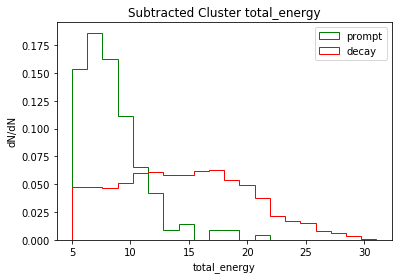

In [225]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['total_energy'].values,groups.get_group(1)['total_energy'].values], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("total_energy")
plt.ylabel("dN/dN")
plt.title("Subtracted Cluster total_energy")
plt.legend()
plt.show()

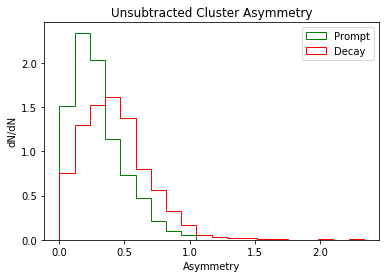

In [226]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['asymmetry'].values,groups.get_group(1)['asymmetry'].values], bins=20,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("Asymmetry")
plt.ylabel("dN/dN")
plt.title("Unsubtracted Cluster Asymmetry")
plt.legend()
plt.show()

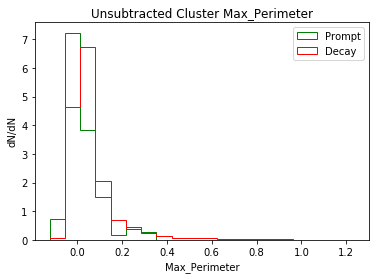

In [227]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['max_perimeter'].values,groups.get_group(1)['max_perimeter'].values], bins=20,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("Max_Perimeter")
plt.ylabel("dN/dN")
plt.title("Unsubtracted Cluster Max_Perimeter")
plt.legend()
plt.show()

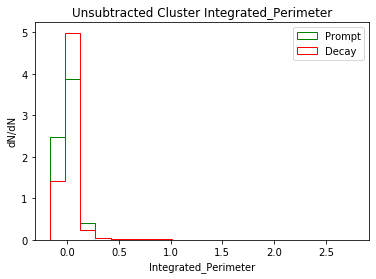

In [228]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['integrated_perimeter'].values,groups.get_group(1)['integrated_perimeter'].values], bins=20,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("Integrated_Perimeter")
plt.ylabel("dN/dN")
plt.title("Unsubtracted Cluster Integrated_Perimeter")
plt.legend()
plt.show()

In [180]:
knn = kNN(train,test)

In [26]:
knn.score()

test score = 0.8994708994708994


In [27]:
knn.best_param()

{'n_neighbors': 32}


In [181]:
lda  = LDA(train,test)

In [231]:
logistic  = Logistic(train,test)

logistic.score()

logistic.best_param()

In [31]:
bdt = BDT(train,test)

In [88]:
bdt.score()

test score = 0.8751529987760098


In [89]:
bdt.best_param()

{'learning_rate': 0.01, 'n_estimators': 10000}


In [234]:
randomForest = RandomForest(train,test)

In [ ]:
randomForest.score()

In [ ]:
randomForest.best_param()

In [32]:
mlp = MLP(train,test)

/Users/francescovassalli/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [80]:
mlp.score()

test score = 0.8531211750305998


In [81]:
mlp.best_param()

{'alpha': 0.0001, 'epsilon': 1e-09, 'hidden_layer_sizes': [17, 17], 'learning_rate_init': 0.1}


Sasha
Logistic
RandomForest


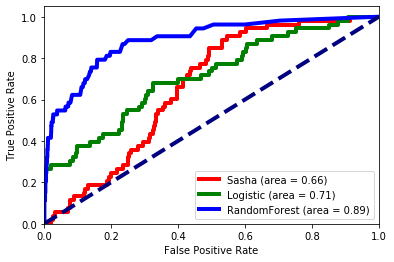

In [301]:
algos = [sasha,logistic,randomForest]
plotRoc(algos)

In [302]:
def csvNoMix(signal):
    df = pd.read_csv(signal)
    df = df.groupby(['isPhoton']).get_group(1)
    df= df.drop(['isPhoton'], axis=1)
    df['pid'] = df['pid'].apply(removeCombined)
    df = df.dropna()
    df['pid'] = df['pid'].apply(pid2Type)
    df = df.rename(columns = {'pid':'isPhoton'})
    return df

In [303]:
signal = preprocess(csvNoMix("photonclusters.csv"))
back = preprocess(csvNoMix("backclusters.csv"))
nclusters =5
#get the sasha prob for the first nclusters
[signal['sProb'].iloc[i] for i in range(0,nclusters)]
[back['sProb'].iloc[i] for i in range(0,nclusters)]

[2.645831659217101e-06,
 0.000328680518208286,
 0.006175663222086786,
 0.005846973736862665,
 0.0002593079898764799]

In [304]:
signal = signal.drop(['isPhoton','sProb'],axis=1)
back = back.drop(['isPhoton','sProb'],axis=1)

In [305]:
logistic.classifier.predict_proba([signal.iloc[i] for i in range(0,nclusters)])

array([[9.99131992e-01, 8.68008203e-04],
       [9.99939172e-01, 6.08284122e-05],
       [9.99393729e-01, 6.06271231e-04],
       [9.99601610e-01, 3.98390010e-04],
       [9.99199695e-01, 8.00305450e-04]])

In [306]:
logistic.classifier.predict_proba([back.iloc[i] for i in range(0,nclusters)])

array([[9.99984276e-01, 1.57243930e-05],
       [9.99964766e-01, 3.52344876e-05],
       [9.99918586e-01, 8.14144578e-05],
       [9.99782772e-01, 2.17227618e-04],
       [9.99789462e-01, 2.10538357e-04]])

In [307]:
randomForest.classifier.predict_proba([signal.iloc[i] for i in range(0,nclusters)])

array([[0.636, 0.364],
       [0.758, 0.242],
       [0.322, 0.678],
       [0.33 , 0.67 ],
       [0.618, 0.382]])

In [308]:
randomForest.classifier.predict_proba([back.iloc[i] for i in range(0,nclusters)])

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.96, 0.04],
       [1.  , 0.  ]])